# Classification test

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

from joblib import dump, load
import time

In [20]:
# df = pd.read_csv("data/BTCUSDT-hour-target-features.csv")
df = pd.read_csv("data/BTCUSDT-minute-target-dip-features.csv")
# df = pd.read_csv("data/BTCUSDT-minute-target-tpsl-features.csv")

# df = pd.read_csv("data/BTCUSDT-hour-target-features-all-rate.csv")
# df = pd.read_csv("data/BTCUSDT-hour-target-features-all-puell.csv")

# df = pd.read_csv("data/BTCUSDT-hour-predict.csv")
# dfd = pd.read_csv("data/classification_test.csv")

In [21]:
df = df.loc[:,~df.columns.duplicated()]

In [28]:
indicators = list(df.columns)[15:]
indicators.append("target")
indicators.append("high")
indicators.append("low")
indicators.append("close")
len(indicators)

48

In [38]:
indicators = ['volume_nvi_o_close_rate_50',
 'mom_srsi_10_d',
 'bb',
 'volatility_dc_wband_10',
 'volatility_bb_pband_100',
 'volatility_bb_wband_200',
 'trend_trix_20_log',
 'trend_vi_50_amp',
 'mom_rsi_30',
 'volume_cmf_50_rate_200',
 'trend_sma_200_diff_o_close_log',
 'mom_ppo_30_hist',
 'trend_sma_50_diff_log',
 'target']

In [122]:
indicators = [
 'volatility_atr_14',
 'volatility_atr_o_close',
 'volatility_bb_wband_10',
 'volatility_bb_pband_100',
 'volatility_bb_wband_200',
 'volatility_bb_hband_o_close',
 'volatility_dc_pband_50',
 'volatility_dc_wband_10',
 'volatility_wband_20',
 'volatility_ui_30',
 'close',
#  'high',
#  'low',
 'target']

In [30]:
d = df.copy()
d = d[list(indicators)].copy().astype(np.float32)
d.replace([np.inf, -np.inf], np.nan, inplace=True)
d.dropna(inplace=True)
ft_split = 200000 #20000
close = d["close"][-ft_split:]
high = d["high"][-ft_split:]
low = d["low"][-ft_split:]

d = d[list(indicators)].copy().astype(np.float32)

X = d.drop(["target", "close", "high", "low"], axis=1, errors="ignore")[:-ft_split]
y = d["target"][:-ft_split]

X_ft = d.drop(["target", "close", "high", "low"], axis=1, errors="ignore")[-ft_split:]
y_ft = d["target"][-ft_split:]
len(X)

1782592

In [31]:
# d = df.copy()
# d.dropna(inplace=True)
# ft_split = 200000

# ft = d[['high', 'low', 'close']].copy().astype(np.float32)[-ft_split:]
# ft.to_csv("data/ft-dip-test.csv", index=False)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
start_time = time.time()
model = RandomForestClassifier()
model.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1754.834354877472 seconds ---


In [40]:
# model = load('models/model_minute_dip_v1.test.joblib') 

## Precision bug documentation

- Not assigning 

Text(-1.5, 0.5, 'Predicted label')

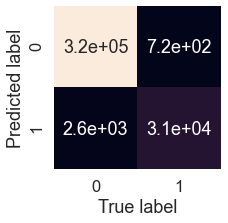

In [34]:
y_preds = model.predict(X_test)	

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                 annot=True,
                 cbar=False)
plt.xlabel("True label")
plt.ylabel("Predicted label")

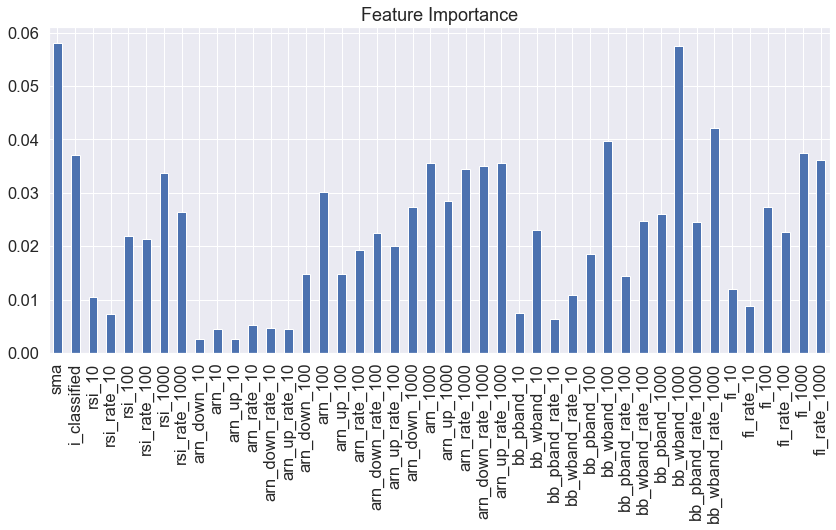

In [35]:
feature_dict = dict(zip(X_train.columns, list(model.feature_importances_)))
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False, figsize=(14, 6));

In [19]:
d = {}
d["precision"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='precision'))
d

{'precision': 0.4969706630919634}

In [ ]:
d["recall"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='recall'))
d

In [ ]:
d["f1"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='f1'))
d

10000
10000


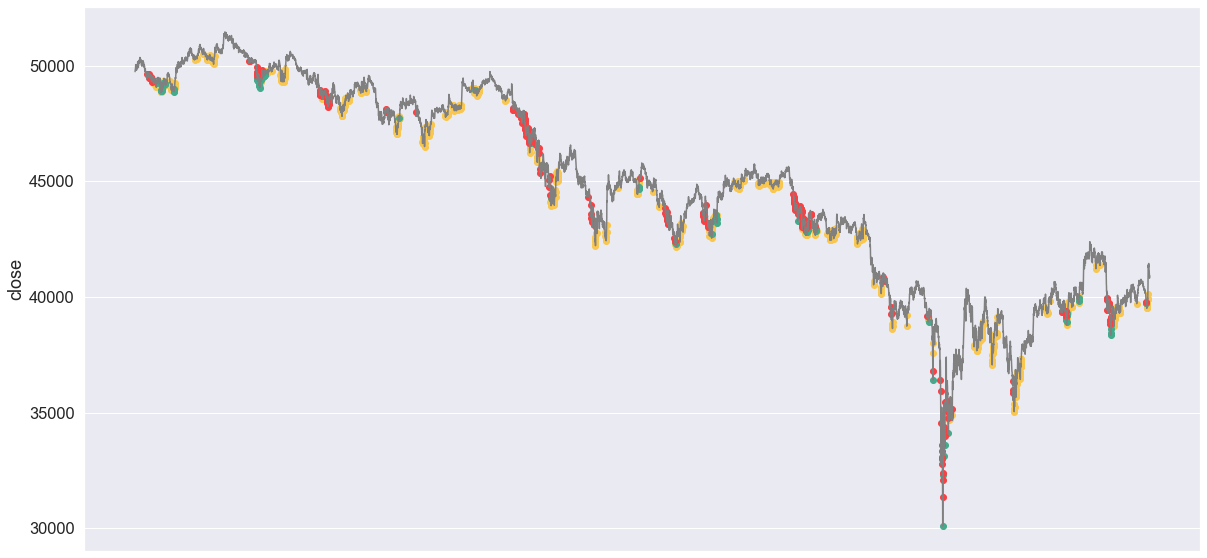

In [49]:
a = 170000
b = 180000 #max 20000
results = model.predict(X_ft[a:b])
scatter_results = list(map(lambda x, c: c if x == 1 else None, results, close[a:b]))

s_correct = list(map(lambda x, t, c: c if x == 1 and t == 1 else None, results, y_ft[a:b], close[a:b]))
s_wrong = list(map(lambda x, t, c: c if x == 1 and t == 0 else None, results, y_ft[a:b], close[a:b]))
s_missed = list(map(lambda x, t, c: c if x == 0 and t == 1 else None, results, y_ft[a:b], close[a:b]))

fig,ax = plt.subplots(figsize=(20, 10))

print(len(close[a:b]))
print(len(scatter_results))

rows = len(close[a:b])

# ax.scatter(range(rows), 
#             scatter_results,
#             color="#43aa8b")


ax.scatter(range(rows), 
            s_missed,
        color="#f9c74f")

ax.scatter(range(rows), 
            s_correct,
        color="#43aa8b")

ax.scatter(range(rows), 
            s_wrong,
        color="#f94144")

ax.set_xlabel("time")
ax.set_ylabel("close")
ax.plot(range(rows),
        close[a:b],
        color="gray")

ax.tick_params(labelbottom=False)
ax.axes.xaxis.set_visible(False)

In [40]:
test = pd.DataFrame(results, columns=["target"])
test["close"] = list(close)
test["high"] = list(high)
test["low"] = list(low)

In [41]:
test.to_csv("data/tpsl-test.csv", index=False)
# X_ft.to_csv("data/xft-dip-test.csv", index=False)

## Documentation of scores
| Modules (in order) | Precision (cv=5) E=error| F1 | TP:FP (TP/FP) | Notes |
| --- | :---: | :---: | :---: | --- |
| ` ` `sma` ` ` `volatility` `volume` | E:0. | 0. | 180/97 | |
| `momentum` `sma` `trend-` `volatility` `volume` | E:0. | 0. |  | |



| `momentum` `sma` `trend-` `volatility` `volume` | E:0. | 0. |  | |



In [55]:
from joblib import dump, load

In [56]:
dump(model, 'models/model_minute_dip_v1.test.joblib') 

['models/model_minute_dip_v1.test.joblib']